In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import plotly.graph_objects as go

from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()

Select all drivers in itineraries that at least finished one itinerary

In [3]:
df_itdr = careful_query("SELECT DISTINCT(driver_id) FROM itineraries WHERE status='finished'")

In [4]:
df_itdr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661 entries, 0 to 2660
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   driver_id  2661 non-null   object
dtypes: object(1)
memory usage: 20.9+ KB


In [5]:
careful_query("SELECT DISTINCT(driver_id) FROM itineraries").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   driver_id  2716 non-null   object
dtypes: object(1)
memory usage: 21.4+ KB


Number of drivers that never finished an itinerary: 2717 - 2661 = 56 (we shoud investigate them later)  
Now let's see one driver that has finished something

In [6]:
df_itdr.head()

driver_id
0  eb271ab2ce67cf017d159cf66a69ba84
1  5408f7b12d5ce92ec0412efbeacfb59a
2  3d53e718a04640e25c111955567efd3d
3  0dca26b7239c1259f14b21c8b86555b7
4  2a0112c852363524351f806318558f8b

We will choose a very particular case. Now let's obtain his availability data

In [7]:
df_av = careful_query("""
SELECT *
FROM availabilities
WHERE driver_id = '1ae9f0b6c2f4504716d2492a290bafd0';
""")
df_av.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60027 entries, 0 to 60026
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   distribution_center  60027 non-null  int64         
 1   id                   60027 non-null  object        
 2   driver_id            60027 non-null  object        
 3   itinerary_id         2014 non-null   object        
 4   lat                  60027 non-null  float64       
 5   lng                  60027 non-null  float64       
 6   sent                 60027 non-null  datetime64[ns]
 7   transport_type       60027 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.7+ MB


In [8]:
df_av.itinerary_id.nunique()

248

Of this uniques one of them is None, meaning that he was just available to receive assignations.  
There are many unique itineraries. Too much information to see on a map. Let's start by filtering some period

In [9]:
df_av.set_index('sent', inplace=True)

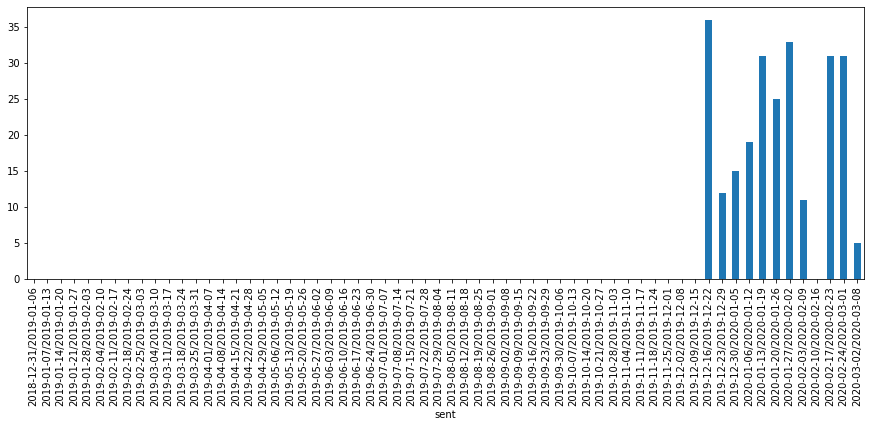

In [10]:
df_av.groupby(df_av.index.to_period('W'))['itinerary_id'].nunique().plot.bar(figsize=(15,5))
plt.xticks(rotation=90);

We are going to select one day from 2019-12-20 to 2019-12-21 inclusive

In [11]:
df_selection = df_av[(df_av.index >= '2019-12-20') & (df_av.index < '2019-12-21')]

In [12]:
# Where do we want to locate the map center?
use_selection_center = True

if use_selection_center:
    # center at our locations average
    longitude = df_selection['lng'].values.mean()
    latitude = df_selection['lat'].values.mean()
else:
    # center at San Pablo, Brazil
    latitude = -23.5475006
    longitude = -46.6361084

In [13]:
# Reference for mapbox layers
# https://plotly.com/python/mapbox-layers/

# Reference for scattermapbox (how to show text)
# https://plotly.com/python/reference/#scattermapbox

In [14]:
#all_map_styles = ["white-bg", "open-street-map", "carto-positron", "carto-darkmatter",
#                  "stamen-terrain", "stamen-toner", "stamen-watercolor"]

In [15]:
# This selection will help to locate agencies one and two
df_ag1 = careful_query("""
SELECT AVG(pickup_lat) as lat, AVG(pickup_lng) as lng from itineraries where distribution_center1=1 limit 1
""")

df_ag2 = careful_query("""
SELECT AVG(pickup_lat) as lat, AVG(pickup_lng) as lng from itineraries where distribution_center1=2 limit 1
""")


In [16]:
fig = go.Figure()

for itinerary, g in df_selection.groupby('itinerary_id'):

    
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = g['lng'].values,
        lat = g['lat'].values,
        name = itinerary,
        text = [(str(g.reset_index().sent.iloc[i]) + itinerary) for i in range(len(g['lng'].values))],#
        #g.reset_index().sent,
        marker = {'size': 10}))

fig.add_trace(go.Scattermapbox(
mode = "markers",
lon = [df_ag1.values[0,1], df_ag2.values[0,1]],
lat = [df_ag1.values[0,0], df_ag2.values[0,0]],
name = 'AGENCIES',
text = str(g.reset_index().sent.iloc[0]),
marker = {'size': 50, 'color':'green'}))

# test this for auto centering:
fig.update_geos(fitbounds="locations")

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': longitude, 'lat': latitude},
        'style': "carto-positron",
        'zoom': 12})

fig.show()

In [17]:
df_selection.itinerary_id.unique()

array([None, 'b179734a6b08edc89f7e5230a5498ef3',
       '0b5c2f5f371cbd712885357812d7c59f',
       'c19c1e0fe12c826369c6343bd130fcd4',
       'c8d3d5b8d933d4368bb837fd9e9ece63',
       '850d0d0cf6f7e741dfa6c7cf65af7e7a',
       'c1ee0c73cd20fe794886739412f01b7a',
       '6135792520130bfed1b3d0cc37116d37',
       '03fc41a491da272aa68079f6ae5a9d42',
       '6333b2ac2d309922a6f830dadab3dba0',
       '182c515bdf1dd86ebc4451d59e28cd3e'], dtype=object)

In [18]:
fig = go.Figure()

for itinerary, g in df_selection.groupby('itinerary_id'):
       
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        lon = [g['lng'].values[0]],
        lat = [g['lat'].values[0]],
        name = 'start',
        text = str(g.reset_index().sent.iloc[0]),
        marker = {'size': 10, 'color':'blue'}))

    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        lon = [g['lng'].values[-1]],
        lat = [g['lat'].values[-1]],
        name = 'end',
        text = str(g.reset_index().sent.iloc[-1]),        
        marker = {'size': 10, 'color': 'red'}))
    


fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = [df_ag1.values[0,1], df_ag2.values[0,1]],
    lat = [df_ag1.values[0,0], df_ag2.values[0,0]],
    name = 'AGENCIES',
    text = str(g.reset_index().sent.iloc[0]),
    marker = {'size': 50, 'color':'green'}))


# test this for auto centering:
#fig.update_geos(fitbounds="locations")

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': longitude, 'lat': latitude},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

In [19]:
# get all pickup location for agency 2
df_ag2_loc = careful_query("""
SELECT  pickup_lat as lat,
        pickup_lng as lng
from itineraries
where distribution_center1=2 
""")

In [20]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = df_ag2_loc.values[:,1],
    lat = df_ag2_loc.values[:,0],
    marker = {'size': 10, 'color': 'red'}))
    
fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = [df_ag1.values[0,1], df_ag2.values[0,1]],
    lat = [df_ag1.values[0,0], df_ag2.values[0,0]],
    name = 'AGENCIES',
    text = str(g.reset_index().sent.iloc[0]),
    marker = {'size': 2, 'color':'green'}))


# test this for auto centering:
#fig.update_geos(fitbounds="locations")

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df_ag2_loc.values[:,1].mean(), 'lat': df_ag2_loc.values[:,0].mean()},
        'style': "carto-positron",
        'zoom': 19})

fig.show()
print('Play with zoom out. You will see some kind of outliers locations')

Play with zoom out. You will see some kind of outliers locations
